<a href="https://colab.research.google.com/github/bksat90/StockPrediction/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# Fetch stock data from Yahoo Finance
ticker = 'IBM'
# 2 years data
data = yf.download(ticker, start="2021-10-01", end="2023-09-30")

# printing the head of the imported data
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-01,134.799240,137.638626,134.196945,137.017212,122.728592,6907889
2021-10-04,136.462708,139.579346,136.089859,137.772461,123.405090,7689251
2021-10-05,138.384323,138.623322,136.367111,136.854691,122.583038,7297524
2021-10-06,136.214142,137.065002,134.694077,136.099426,121.906540,5573506
2021-10-07,136.453156,137.093689,135.305923,135.573608,121.435539,3999695


In [3]:
# seperate the close data which will be used for prediction
close_data = data['Close'].values.reshape(-1,1)

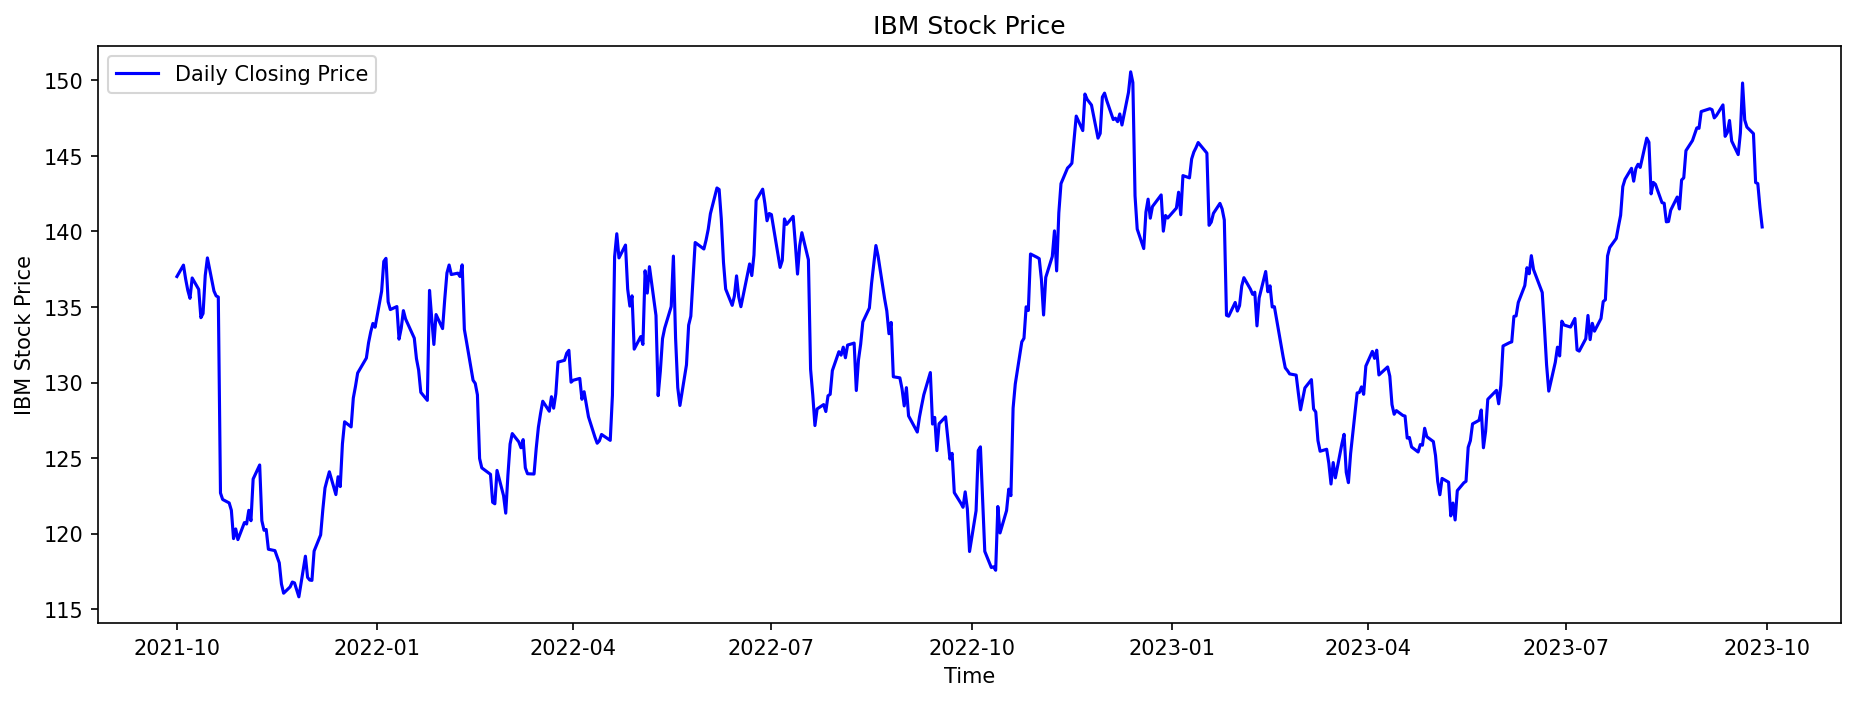

In [4]:
# Plot the close data
plt.figure(figsize=(15,5), dpi=150)
plt.plot(data.index, data['Close'], color='blue', label='Daily Closing Price')
plt.title(f'IBM Stock Price')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [5]:
# preprocessing - rescaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(close_data)

## Creating the time series data structure with structure N * T * D
# N = number of samples, T = block/series size = look_back, D = features = 1
look_back = 60

# 80% data is considered as train data
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

# generates time series data
train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)

In [6]:
# builds the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,
                    input_shape=(look_back, 1)))
model.add(LSTM(units=100,return_sequences = True))
model.add(LSTM(units=100))
model.add(Dense(1, activation='tanh'))

In [7]:
# display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           60400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 151301 (591.02 KB)
Trainable params: 151301 (591.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


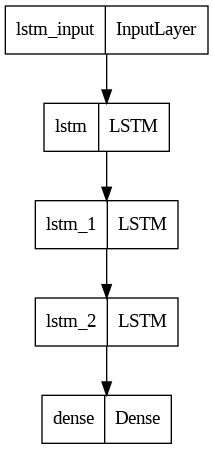

In [8]:
# display the model
plot_model(model)

In [9]:
# compiles the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics = ['accuracy'])

In [10]:
# fit the model
r = model.fit(train_generator,
              validation_data=(test_generator),
              epochs=10)

Epoch 1/10
18/18 [==============================] - 12s 312ms/step - loss: 0.4712 - accuracy: 0.0000e+00 - val_loss: 0.3554 - val_accuracy: 0.0000e+00
Epoch 2/10
18/18 [==============================] - 5s 261ms/step - loss: 0.3947 - accuracy: 0.0000e+00 - val_loss: 0.3435 - val_accuracy: 0.0000e+00
Epoch 3/10
18/18 [==============================] - 4s 245ms/step - loss: 0.3001 - accuracy: 0.0000e+00 - val_loss: 0.3097 - val_accuracy: 0.0000e+00
Epoch 4/10
18/18 [==============================] - 4s 246ms/step - loss: 0.2880 - accuracy: 0.0000e+00 - val_loss: 0.2876 - val_accuracy: 0.0000e+00
Epoch 5/10
18/18 [==============================] - 5s 258ms/step - loss: 0.2640 - accuracy: 0.0000e+00 - val_loss: 0.2557 - val_accuracy: 0.0000e+00
Epoch 6/10
18/18 [==============================] - 4s 245ms/step - loss: 0.2578 - accuracy: 0.0000e+00 - val_loss: 0.2945 - val_accuracy: 0.0000e+00
Epoch 7/10
18/18 [==============================] - 5s 295ms/step - loss: 0.2336 - accuracy: 0.0000

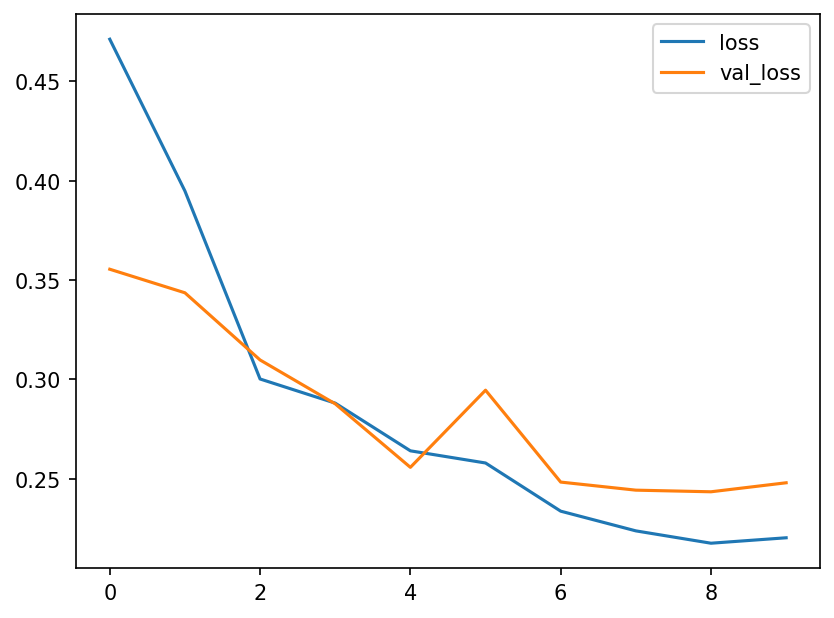

In [11]:
# plot the loss vs value loss of the model for the training data
plt.figure(dpi=150)
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [12]:
# Predicting on the test data
data_predictions = model.predict(test_generator)

# Invert predictions
data_predictions = scaler.inverse_transform(data_predictions)
actual_close_prices = scaler.inverse_transform(test_data[look_back:])

101/101 [==============================] - 4s 21ms/step


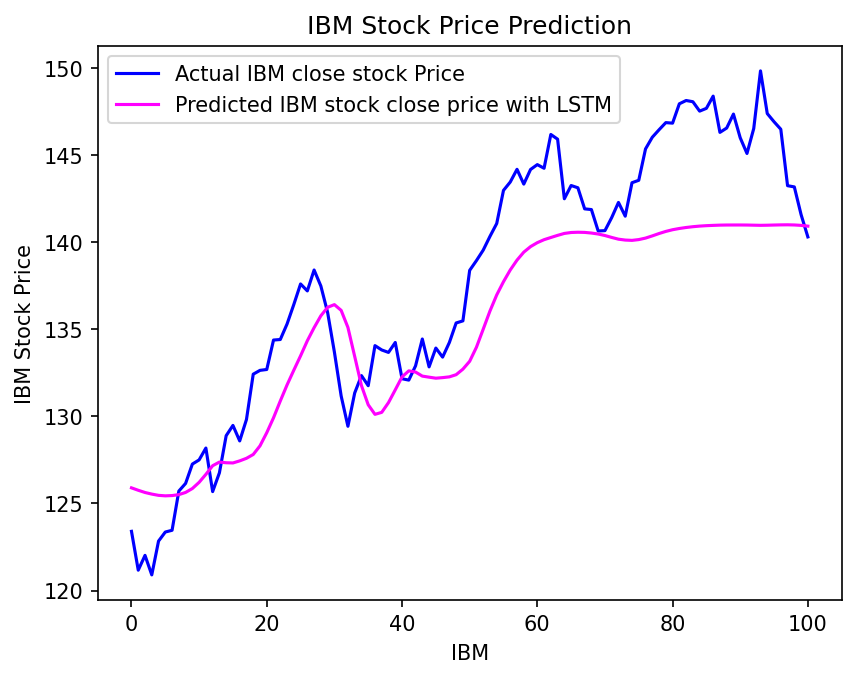

In [13]:
# Plot the data
plt.figure(dpi=150)
plt.plot(actual_close_prices, color='blue', label='Actual IBM close stock Price')
plt.plot(data_predictions, color='magenta', label='Predicted IBM stock close price with LSTM')
plt.title('IBM Stock Price Prediction')
plt.xlabel('IBM')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()

In [14]:
# future prediction
def predict_future_days(model, base_data, days_to_predict, scaler, look_back=2000):
    """This function predicts the stock for the future dates
    """
    # Start with the last days of the base data
    input_data = base_data[-look_back:].reshape(1, look_back, 1)

    # Predict future days
    future_predictions = []

    for _ in range(days_to_predict):
        # Make a prediction
        prediction = model.predict(input_data)

        # Append the prediction
        future_predictions.append(prediction[0, 0])

        # Update the input data to include the prediction and exclude the oldest data point
        # Correctly reshape the prediction to (1, 1, 1) before appending
        input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Invert the scaling
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions

In [15]:
# Predict next 30 days
days_to_predict = 60
future_days = predict_future_days(model, scaled_data, days_to_predict, scaler, look_back)

1/1 [==============================] - 0s 36ms/step


<ipython-input-16-4eb481a56c78>:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_dates = pd.date_range(start=data.index[-1], periods=days_to_predict + 1, closed='right')


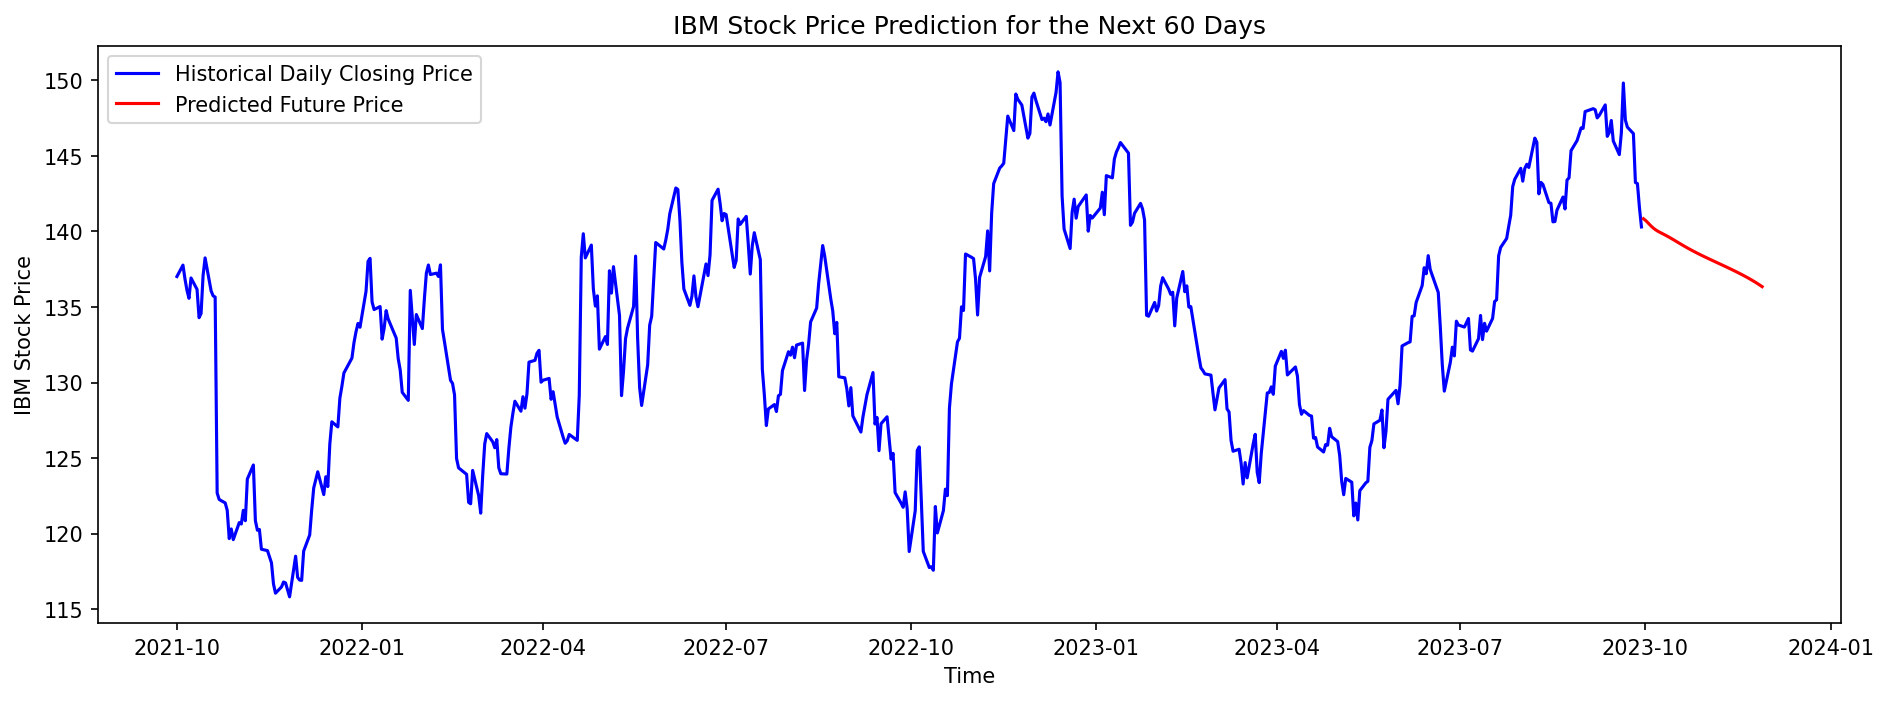

In [16]:
# Plot the predictions
predicted_dates = pd.date_range(start=data.index[-1], periods=days_to_predict + 1, closed='right')
plt.figure(figsize=(15,5), dpi=150)
plt.plot(data.index, data['Close'], color='blue', label='Historical Daily Closing Price')
plt.plot(predicted_dates, future_days, color='red', label='Predicted Future Price')
plt.title(f'IBM Stock Price Prediction for the Next {days_to_predict} Days')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show();